---
title: "Agentic workflows from scratch with (and without) LangGraph"
date: 2025-07-03
description-meta: "How to build frequently used workflows from scratch and with LangGraph"
categories:
  - llm
  - python
  - anthropic
  - openai
  - agents
---

These days, everyone is "building" agents. But, in my experience, they're either not really building agents, or they shouldn't be! 

Agents are powerful tools, but they're not the right tool for many business problems. They give a lot of responsibility to LLMs, and that's not always a good idea.

Their counterpart, agentic workflows, are a more controlled way to use LLMs. They're a good fit for many business problems, and they're a lot easier to build than agents.

In this post, I'll explain what an agent is, what an agentic workflow is, and how to choose between them. I'll also show you how to build the most common agentic workflows. 

This post is based on [Anthropic's Building Effective Agents](https://www.anthropic.com/engineering/building-effective-agents). I encourage you to read it. 

## What is an agent?

Over time, the ecosystem has converged on similar definitions:

Anthropic's definition: 

> "Systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks."
>
> [Building Effective Agents](https://www.anthropic.com/engineering/building-effective-agents), Anthropic

OpenAI's definition:

> "Systems that independently accomplish tasks on behalf of users"
>
> [New tools for building agents](https://openai.com/index/new-tools-for-building-agents/), OpenAI

LangChain's definition: 

> "system that uses an LLM to decide the control flow of an application."
>
> [What is an agent?](https://blog.langchain.com/what-is-an-agent/), LangChain

These definitions share the idea that agents are systems that can:

1. Make decisions
2. Use tools
3. Take actions
4. Accomplish goals without constant human guidance

This gives us a clear delimiter as to what an agent is and what it is not. However, this definition leaves out the majority of agentic systems being build by companies right now. These systems are called **agentic workflows**.

## What is an agentic workflow?

Anthropic defines agentic workflows as systems where "LLMs and tools are orchestrated through predefined code paths". They're different from agents in that they don't have the ability to dynamically direct their own processes and tool usage.

Workflows sound less sexy than agents, so you would rarely hear someone say they're building workflows. However, in my experience, most people are (or should be) building workflows.

## How to choose between agentic workflows and agents?

Choose agents for open-ended tasks where the number and the order of steps is not known beforehand. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. 

For example, a coding assistant is a good candidate for an agent. When you ask it to implement a feature, there's no predefined path nor the order of steps is known beforehand. It might need to create files, add new dependencies, edit existing files, etc.

Agentic workflows make sense for tasks where the number and the order of steps is known beforehand. For example, an AI assistant that generates an initial draft of an article based on internal data sources. The order of steps are likely known beforehand (e.g., retrieve the key information from the internal data sources, generate a first candidate, and then revise the article).

## What is LangGraph?

LangGraph is a graph-based framework for building complex LLM applications, designed for stateful workflows. It enables complex agent architectures with minimal code.

It uses a graph-based approach to build agentic systems. The graph is composed of nodes and edges. Nodes are the units of work (functions, tools, models). Edges define the workflow paths between nodes. State is persistent data passed between nodes and updated through reducers.

I've built many workflows from scratch, and I've realized that I often end up reinventing the same patterns that frameworks like LangGraph provide. I like LangGraph because it provides you with easy-to-use components, a simple API, and it lets you visualize your workflow. It also integrates well with LangSmith, a tool for monitoring and debugging LLM applications.

In this tutorial, I'll show you how to build common agentic workflows with and without LangGraph. I'll use *LangChain* as a thin wrapper on top of OpenAI models.

## Prerequisites

To follow this tutorial you'll need to:

1. Sign up and generate an API key in [OpenAI](https://platform.openai.com/docs/overview).
2. Set the API key as an environment variable called `OPENAI_API_KEY`.
3. Create a virtual environment in Python and install the requirements:

```bash
python -m venv venv
source venv/bin/activate
pip install langchain langchain-openai langchain-community langgraph jupyter nest_asyncio
```

Once you've completed the steps above, you can run the code from this article. You can also download the notebook from [here](https://github.com/dylanjcastillo/blog/tree/main/posts/agentic-workflows-langgraph-pyndantic-ai.ipynb).

You also need to apply a small patch to make sure you can run asyncio inside the notebook:

In [1]:
import nest_asyncio

nest_asyncio.apply()

You will use `asyncio` inside the notebook, so you need to install and apply `nest_asyncio`. Otherwise, you'll get a `RuntimeError` when running the code.

## Workflows

As usual, you must start by importing the necessary libraries and loading the environment variables. You'll use the same model in all the examples, so you'll define it once here: 

In [44]:
# | output: false

import asyncio
import operator
from typing import Annotated, Literal, Optional, TypedDict

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

load_dotenv()

model = ChatOpenAI(model="gpt-4.1-mini")

This code imports the necessary libraries for building agentic workflows:

- **LangChain**: For working with LLMs, messages, and structured outputs
- **LangGraph**: For building stateful workflows with nodes and edges
- **Pydantic**: For data validation and structured data models

The `load_dotenv()` function loads environment variables from a `.env` file, including your OpenAI API key. You also define model (`gpt-4.1-mini`) that you'll use in all the examples.

### Prompt chaining

This workflow is designed for tasks that can be easily divided into subtasks. The key trade-off is accepting longer completion times (higher latency) in exchange for a higher-quality result.

Here's what the workflow looks like:

```{mermaid}
flowchart LR
    In --> LLM1["LLM Call 1"]
    LLM1 -- "Output 1" --> Gate{Gate}
    Gate -- Pass --> LLM2["LLM Call 2"]
    Gate -- Fail --> Exit[Exit]
    LLM2 -- "Output 2" --> LLM3["LLM Call 3"]
    LLM3 --> Out
```

**Examples:**

- Generating content in a pipeline by generating table of contents, content, revisions, translations, etc.
- Generating a text through a multi-step process to evaluate if it matches certain criteria

Now I'll show you how to implement a prompt chaining workflow for generating an article. The workflow will be composed of three steps:

1. Generate a table of contents for the article
2. Generate the content of the article
3. Revise the content of the article if it's too long

I'll show you a vanilla implementation and then a LangGraph implementation.

#### Vanilla (+LangChain)

First, you need to define the state of the workflow and a model to use for the LLM. You'll use Pydantic for the state and LangChain for the model.

In [3]:
class State(BaseModel):
    topic: str
    table_of_contents: Optional[str] = None
    content: Optional[str] = None
    revised_content: Optional[str] = None

Then, you need to define the functions that will be used in the workflow:

In [4]:
def generate_table_of_contents(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state.topic}"
        ),
    ]
    return model.invoke(messages).content


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state.topic} with the following table of contents: {state.table_of_contents}"
        ),
    ]
    return model.invoke(messages).content


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of an article about {state.topic} with the following table of contents: {state.table_of_contents} and the following content:\n\n{state.content}"
        ),
    ]
    return model.invoke(messages).content

These functions provide the core functionality of the workflow. They follow the steps I outlined above:

1. `generate_table_of_contents`: Generate a table of contents for the article
2. `generate_article_content`: Generate the content of the article
3. `revise_article_content`: Revise the content of the article if it's too long

Then we need to orchestrate the workflow. You'll do that by creating a function that takes a topic and returns the final article.

In [5]:
def run_workflow(topic: str) -> State:
    article = State(topic=topic)
    article.table_of_contents = generate_table_of_contents(article)
    article.content = generate_article_content(article)
    if len(article.content) > 1000:
        article.revised_content = revise_article_content(article)
    return article


output = run_workflow("Artificial Intelligence")

`run_workflow` takes the topic provided by the user, generates an article, and verifies that it's below 1000 characters. Depending on the result, it will revise the article or not. Finally, it returns the state that contains all the results from the workflow (the table of contents, the content, and the revised content).

#### LangGraph

Now let's see how to implement the same workflow using LangGraph. You will noticed two key differences compared to the vanilla implementation.

Similar to the vanilla implementation, you'll start by initializing the state class:

In [6]:
class State(TypedDict):
    topic: str
    table_of_contents: str
    content: str
    revised_content: str

When working with LangGraph, I'd suggest to use a `TypedDict` to manage your state. Using a Pydantic model to manage your state in LangGraph has a few downsides: 

1. Data types are only checked when they enter a node, not when they exit. This means you could accidentally save data of the wrong type to your state. 
2. The final output of the entire graph will be a dictionary, not your Pydantic model.
3. The implementation feels like it's [half-baked](https://github.com/langchain-ai/langgraph/discussions/1306).

For more details, check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#use-pydantic-models-for-graph-state).

Then, you'll define the nodes (functions) that will be used in the workflow.

In [7]:
def generate_table_of_contents(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state['topic']}"
        ),
    ]
    return {"table_of_contents": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['topic']} with the following table of contents: {state['table_of_contents']}"
        ),
    ]
    return {"content": model.invoke(messages).content}


def check_article_content(state: State) -> str:
    if len(state["content"]) > 1000:
        return "Fail"
    return "Pass"


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of an article about {state['topic']} with the following table of contents: {state['table_of_contents']} and the following content:\n\n{state['content']}"
        ),
    ]
    return {"revised_content": model.invoke(messages).content}

You'll noticed that the functions are quite similar to the vanilla implementation. The only difference is that they return dictionaries that automatically update the state rather than you having to do it manually.

Then you need to specify the nodes and edges of the workflow:

In [8]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)

workflow_builder.add_edge(START, "generate_table_of_contents")
workflow_builder.add_edge("generate_table_of_contents", "generate_article_content")
workflow_builder.add_conditional_edges(
    source="generate_article_content",
    path=check_article_content,
    path_map={"Fail": "revise_article_content", "Pass": END},
)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()

You initialize a `StateGraph` object, which is a builder for the workflow. Then you add nodes to the graph, and define the edges between them. The nodes in the graphs are the functions that you defined earlier. In the conditional edge, you can define the path that the workflow will take based on the state of the workflow.

The `compile` method is used to compile the graph into a callable workflow.

Finally, LangGraph has a nice feature that allows you to visualize the workflow. You can use the `get_graph` and `draw_mermaid_png` for that:

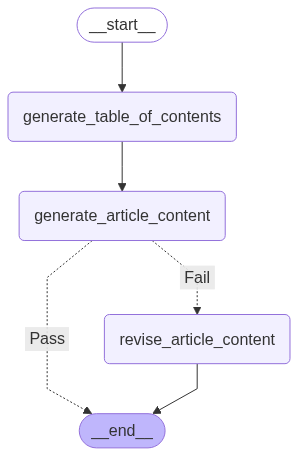

In [9]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Finally, you can run the workflow by calling the `invoke` method on the compiled workflow and provide the initial state.

In [10]:
article = workflow.invoke({"topic": "Artificial Intelligence"})

And you'll get the following output:

In [11]:
article

{'topic': 'Artificial Intelligence',
 'table_of_contents': 'Table of Contents\n\n1. Introduction to Artificial Intelligence  \n2. History and Evolution of AI  \n3. Types of Artificial Intelligence  \n4. Applications of AI in Various Industries  \n5. Benefits of Artificial Intelligence  \n6. Challenges and Ethical Considerations  \n7. The Future of Artificial Intelligence  \n8. Conclusion',
 'content': '# Artificial Intelligence: Transforming the Future\n\n## 1. Introduction to Artificial Intelligence\n\nArtificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning, reasoning, problem-solving, perception, and language understanding. AI enables machines to perform tasks that typically require human intelligence, making them smarter, more efficient, and capable of handling complex scenarios. From virtual assistants and recommendation systems to autonomous vehicles, AI has become an integral 

That's it for prompt chaining. Next, you'll see how to implement a routing workflow.

### Routing

Routing is a sorting system that sends each task to the right place for the best handling. This process can be managed by an LLM or a traditional classification model. It makes sense to use when a system needs to apply different logic to different types of queries.

Here's what the workflow looks like:

```{mermaid}
flowchart LR 
    In([In]) --> Router["LLM Call Router"]

    Router -->|Route 1| LLM1["LLM Call 1"]
    Router -->|Route 2| LLM2["LLM Call 2"]
    Router -->|Route 3| LLM3["LLM Call 3"]

    LLM1 --> Out([Out])
    LLM2 --> Out
    LLM3 --> Out
```

**Examples:**

- Classify complexity of question and adjust model depending on it
- Classify type of query and use specialized tools (e.g., indexes, prompts)

I'll walk you through a simple example of a routing workflow. The workflow will be composed of two steps:

1. Classify the type of query
2. Route the query to the right place

I'll show you a vanilla implementation and then a LangGraph implementation.

#### Vanilla (+LangChain)

First, you need to initialize the model, and define the state of the workflow and the data models. You'll use Pydantic for the state and data models validation and LangChain for the LLM interactions.

In [12]:
class State(BaseModel):
    input: str
    type: Optional[
        Literal["write_article", "generate_table_of_contents", "review_article"]
    ] = None
    output: Optional[str] = None


class MessageType(BaseModel):
    type: Literal["write_article", "generate_table_of_contents", "review_article"]

Then, you need to define the functions that will be used in the workflow.

In [13]:
def classify_message(state: State) -> State:
    model_with_str_output = model.with_structured_output(MessageType)
    messages = [
        SystemMessage(
            content="You are a helpful assistant. You will classify the message into one of the following categories: 'write_article', 'generate_table_of_contents', 'review_article'."
        ),
        HumanMessage(content=f"Classify the message: {state.input}"),
    ]
    return model_with_str_output.invoke(messages).type


def write_article(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will write an article about the topic provided."
        ),
        HumanMessage(content=f"Write an article about {state.input}"),
    ]
    return model.invoke(messages).content


def generate_table_of_contents(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will generate a table of contents for an article about the topic provided."
        ),
        HumanMessage(
            content=f"Generate a table of contents for an article about {state.input}"
        ),
    ]
    return model.invoke(messages).content


def review_article(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will review the article for the topic provided."
        ),
        HumanMessage(content=f"Review the article for the topic {state.input}"),
    ]
    return model.invoke(messages).content

These functions handle the core functionality of the workflow:

1. `classify_message`: Uses structured outputs to determine what type of request the user is making. This is the "router" that decides which path to take.
2. `write_article`: Generates a full article about the given topic
3. `generate_table_of_contents`: Creates only a table of contents for an article
4. `review_article`: Provides a review or critique of an existing article

Finally, you need to orchestrate the workflow by creating a function that classifies the input and routes it to the appropriate handler.

In [14]:
def run_workflow(message: str) -> str:
    state = State(input=message)
    state.type = classify_message(state)
    if state.type == "write_article":
        return write_article(state)
    elif state.type == "generate_table_of_contents":
        return generate_table_of_contents(state)
    elif state.type == "review_article":
        return review_article(state)
    else:
        return "I'm sorry, I don't know how to handle that message."

output = run_workflow("Write an article about the meaning of life")

`run_workflow` takes the user's message, classifies it to determine the intent, and then routes it to the appropriate specialized function. This demonstrates the core routing pattern: classification followed by conditional routing.

Now let's implement the same workflow using LangGraph. 

#### LangGraph

Similar to the vanilla implementation, you'll start by defining the state and data models:

In [15]:
class State(TypedDict):
    input: str
    type: Optional[Literal["write_article", "generate_table_of_contents", "review_article"]] = None
    output: Optional[str] = None


class MessageType(BaseModel):
    type: Literal["write_article", "generate_table_of_contents", "review_article"]

Then, you'll define the nodes (functions) that will be used in the workflow:

In [16]:
def classify_message(message: str) -> dict:
    model_with_str_output = model.with_structured_output(MessageType)
    messages = [
        SystemMessage(
            content="You are a writer. You will classify the message into one of the following categories: 'write_article', 'generate_table_of_contents', 'review_article'."
        ),
        HumanMessage(content=f"Classify the message: {message}"),
    ]
    return {"type": model_with_str_output.invoke(messages).type}


def route_message(state: State) -> State:
    if state["type"] == "write_article":
        return "generate_article_content"
    elif state["type"] == "generate_table_of_contents":
        return "generate_table_of_contents"
    elif state["type"] == "review_article":
        return "revise_article_content"
    else:
        raise ValueError(f"Invalid message type: {state['type']}")


def generate_table_of_contents(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of the following article:\n\n{state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}

The functions are similar to the vanilla implementation, but they return dictionaries that automatically update the state rather than requiring manual state management. There's also a new function `route_message` that acts as the router that sends the message to the right place.

Then, you need to specify the nodes and edges of the workflow:

In [17]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("classify_message", classify_message)
workflow_builder.add_conditional_edges(
    "classify_message",
    route_message,
    {
        "generate_article_content": "generate_article_content",
        "generate_table_of_contents": "generate_table_of_contents",
        "revise_article_content": "revise_article_content",
    },
)

workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)

workflow_builder.add_edge(START, "classify_message")
workflow_builder.add_edge("generate_table_of_contents", END)
workflow_builder.add_edge("generate_article_content", END)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()

First, you'll start by creating a `StateGraph` object, which serves as the builder for your workflow. Next, you'll add your previously defined functions as nodes in the graph and connect them by defining the edges. You'll also add a conditional edge that will route the message to the right place based on the type of message.

The graph is then compiled into a runnable workflow using the `compile` method.

Finally, LangGraph includes a helpful feature for visualizing your workflow. For this, you can use the `get_graph` and `draw_mermaid_png` functions.

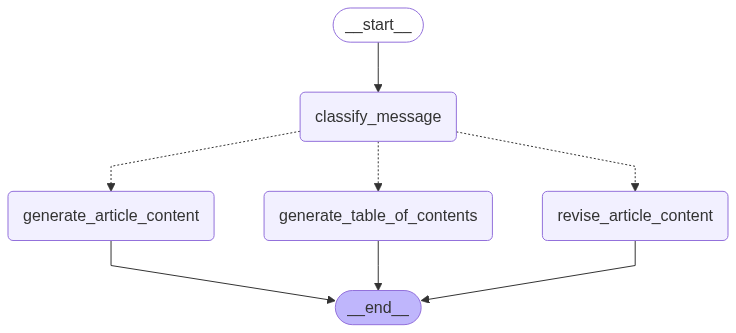

In [18]:
display(Image(workflow.get_graph().draw_mermaid_png()))

### Parallelization

This workflow is designed for tasks that can be easily divided into independent subtasks. The key trade-off is managing complexity and coordination overhead in exchange for significant speed improvements or diverse perspectives.

Here's what the workflow looks like:

```{mermaid}
flowchart LR
    In([In]) --> LLM1["LLM Call 1"]
    In --> LLM2["LLM Call 2"]
    In --> LLM3["LLM Call 3"]
    LLM1 --> Aggregator["Aggregator"] 
    LLM2 --> Aggregator["Aggregator"] 
    LLM3 --> Aggregator["Aggregator"] 
    Aggregator --> Out([Out])
```

**Examples:**

- Evaluate multiple independent aspects of a text (safety, quality, relevance)
- Process user query and apply guardrails in parallel
- Generate multiple response candidates given a query for comparison

Now I'll show you how to implement a parallelization workflow for content evaluation. The workflow will be composed of three steps:

1. Run multiple independent evaluations of the same content
2. Collect all evaluation results
3. Aggregate the results into a final assessment

I'll show you a vanilla implementation and then a LangGraph implementation.

#### Vanilla (+LangChain)

First, you need to define the state of the workflow and data models for evaluations. You'll use Pydantic for the state and data models validation and LangChain for the LLM interactions. 

In [19]:
class Evaluation(BaseModel):
    explanation: str
    is_appropiate: bool


class AggregatedResults(BaseModel):
    summary: str
    is_appropiate: bool


class State(BaseModel):
    input: str
    evaluations: Optional[list[Evaluation]] = None
    aggregated_results: Optional[AggregatedResults] = None

Then, you need to define the functions with each step of the workflow. 

In [20]:
async def evaluate_text(state: State) -> Evaluation:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's appropriate for a general audience."
        ),
        HumanMessage(content=f"Evaluate the following text: {state.input}"),
    ]
    response = await model_with_str_output.ainvoke(messages)
    return response


async def aggregate_results(state: State) -> State:
    model_with_str_output = model.with_structured_output(AggregatedResults)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a list of evaluations, you will summarize them and provide a final evaluation."
        ),
        HumanMessage(
            content=f"Summarize the following evaluations:\n\n{[(eval.explanation, eval.is_appropiate) for eval in state.evaluations]}"
        ),
    ]
    response = await model_with_str_output.ainvoke(messages)
    return response


async def run_workflow(input: str) -> State:
    state = State(input=input)

    evaluation_tasks = [evaluate_text(state) for _ in range(3)]
    state.evaluations = await asyncio.gather(*evaluation_tasks)

    aggregated_results = await aggregate_results(state)
    state.aggregated_results = aggregated_results
    return state


output = await run_workflow(
    "There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids."
)

These functions provide the core functionality of the workflow. They follow the steps I outlined above:

1. `evaluate_text`: Evaluates whether the provided text is appropriate for a general audience
2. `aggregate_results`: Combines multiple evaluation results into a final assessment
3. `run_workflow`: Orchestrates the workflow by running multiple evaluations in parallel using `asyncio.gather()`. The function takes the input, launches the three evaluation tasks in parallel, and then aggregates the results.

Here's the output:

In [21]:
print("Input:", output.input)
print("Individual evaluations:")
for i, eval in enumerate(output.evaluations):
    print(f"  Evaluation {i + 1}: {eval.is_appropiate} - {eval.explanation}")
print("Overall appropriate:", output.aggregated_results.is_appropiate)
print("Summarized evaluations:", output.aggregated_results.summary)

Input: There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids.
Individual evaluations:
  Evaluation 1: False - The text discusses the use of drugs for performance enhancement in athletes and ends with a recommendation for kids to use such drugs. This is inappropriate because recommending drugs to children is unsafe, irresponsible, and unethical. Such content is not suitable for a general audience, especially minors.
  Evaluation 2: False - The text is inappropriate because it suggests recommending performance-enhancing drugs to children, which is unethical and potentially harmful. Such content is not suitable for a general audience.
  Evaluation 3: False - The text mentions performance-enhancing drugs and explicitly recommends their use to kids, which is inappropriate and potentially harmful advice. Such content is not suitable for a general audience, especially children, as i

Next, you'll implement this same workflow using LangGraph.

#### LangGraph

First, you'll use Pydantic to define the state and data models the LLM will use.

In [22]:
class Evaluation(BaseModel):
    is_appropiate: bool = Field(
        description="Whether the text is appropriate for a general audience"
    )
    explanation: str = Field(description="The explanation for the evaluation")


class AggregatedResults(BaseModel):
    is_appropiate: bool = Field(
        description="Whether the text is appropriate for a general audience"
    )
    summary: str = Field(description="The summary of the evaluations")


class State(TypedDict):
    input: str
    evaluations: Annotated[list, operator.add]
    aggregated_results: AggregatedResults

Then, you must define the functions for each node in the workflow. 

In [23]:
def evaluate_text(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's appropriate for a general audience."
        ),
        HumanMessage(content=f"Evaluate the following text: {state['input']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluations": [response]}


def aggregate_results(state: State) -> str:
    model_with_str_output = model.with_structured_output(AggregatedResults)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a list of evaluations, you will summarize them and provide a final evaluation."
        ),
        HumanMessage(
            content=f"Summarize the following evaluations:\n\n{[(eval.explanation, eval.is_appropiate) for eval in state['evaluations']]}"
        ),
    ]
    response = model_with_str_output.invoke(messages)
    return {"aggregated_results": response}

The functions are similar to the vanilla implementation, but they return dictionaries that automatically update the state. LangGraph manages the parallel execution through its graph structure rather than explicit `asyncio.gather()`, which is nice, if you don't like messing around with `async` code.

Then, you need to specify the nodes and edges of the workflow:

In [24]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("evaluate_text_1", evaluate_text)
workflow_builder.add_node("evaluate_text_2", evaluate_text)
workflow_builder.add_node("evaluate_text_3", evaluate_text)

workflow_builder.add_node("aggregate_results", aggregate_results)

workflow_builder.add_edge(START, "evaluate_text_1")
workflow_builder.add_edge(START, "evaluate_text_2")
workflow_builder.add_edge(START, "evaluate_text_3")

workflow_builder.add_edge("evaluate_text_1", "aggregate_results")
workflow_builder.add_edge("evaluate_text_2", "aggregate_results")
workflow_builder.add_edge("evaluate_text_3", "aggregate_results")

workflow_builder.add_edge("aggregate_results", END)

workflow = workflow_builder.compile()

You initialize a `StateGraph` object, which is used to build the workflow. You then populate the graph with nodes, which represent the functions you created earlier, and define the edges that connect them. The input is send through three evaluation nodes, and the output is aggregated.

To transform the graph into an executable object, you use the `compile` method.

Lastly, LangGraph offers a convenient feature to see a visual representation of the graph. This can be done with the `get_graph` and `draw_mermaid_png` functions.

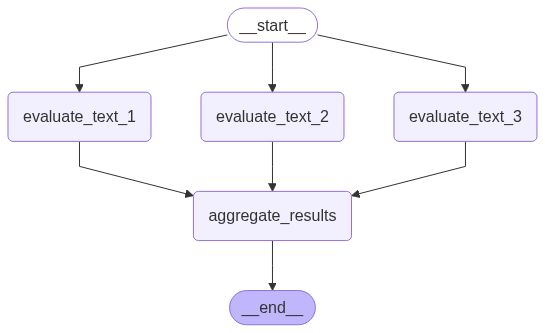

In [25]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Here's the output of the workflow:

In [26]:
output = workflow.invoke({"input": "There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids."})
output

{'input': 'There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids.',
 'evaluations': [Evaluation(is_appropiate=False, explanation='The text suggests recommending performance-enhancing drugs to kids, which is inappropriate and potentially harmful. Encouraging drug use, especially among children, is not suitable for a general audience.'),
  Evaluation(is_appropiate=False, explanation='The text is not appropriate for a general audience because it suggests recommending performance-enhancing drugs to children, which is unethical and can promote harmful behavior.'),
  Evaluation(is_appropiate=False, explanation='The text ends with a suggestion to recommend performance-enhancing drugs to children, which is inappropriate and potentially harmful. Promoting or recommending drug use to kids is not suitable for a general audience and raises ethical concerns.')],
 'aggregated_results': Agg

Next, you'll learn how to implement the Orchestrator-worker pattern. 

### Orchestrator-workers

This workflow works well for tasks where you don't know the required subtasks beforehand. The subtasks are determined by the orchestrator.

Here's what the workflow looks like:

```{mermaid}
flowchart LR
    In([In]) --> Orch[Orchestrator]

    Orch -.-> LLM1["LLM Call 1"]
    Orch -.-> LLM2["LLM Call 2"]
    Orch -.-> LLM3["LLM Call 3"]

    LLM1 -.-> Synth[Synthesizer]
    LLM2 -.-> Synth
    LLM3 -.-> Synth

    Synth --> Out([Out])
```

**Examples:**

- Coding tools making changes to multiple files at once
- Searching multiple sources and synthesize the results

I'll walk through an example of how to implement this pattern. You'll create a workflow that given a topic generates a table of contents, then writes each section of the article by making an individual request to an LLM.

#### Vanilla (+LangChain)

You must start by defining the state and the data models used in the workflow. 

In [27]:
class Section(BaseModel):
    name: str = Field(description="The name of the section")
    description: str = Field(description="The description of the section")


class CompletedSection(BaseModel):
    name: str = Field(description="The name of the section")
    content: str = Field(description="The content of the section")


class Sections(BaseModel):
    sections: list[Section] = Field(description="The sections of the article")


class OrchestratorState(BaseModel):
    topic: str
    sections: Optional[list[Section]] = None
    completed_sections: Optional[list[CompletedSection]] = None
    final_report: Optional[str] = None

Then, you need to define the functions for each step in the workflow:

In [28]:
async def plan_sections(state: OrchestratorState):
    model_planner = model.with_structured_output(Sections)
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the sections for a short article."
        ),
        HumanMessage(
            content=f"Generate the sections of an article about {state.topic}"
        ),
    ]
    response = await model_planner.ainvoke(messages)
    return response.sections


async def write_section(section: Section) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {section.name} with the following description: {section.description}"
        ),
    ]
    response = await model.ainvoke(messages)
    return CompletedSection(name=section.name, content=response.content)


def synthesizer(state: OrchestratorState) -> str:
    completed_sections_str = "\n\n".join(
        [section.content for section in state.completed_sections]
    )
    return completed_sections_str

You've defined these functions:

1. `plan_sections`: This function generates the sections for an article.
2. `write_section`: This function writes a section of an article.
3. `synthesizer`: This function synthesizes the final report.

In this case, you cannot use a parallelization workflow because beforehand you don't know how many sections you will need to write. The orchestrator defines that dynamically.

Next, you'll define the function that runs the workflow:

In [29]:
async def run_workflow(topic: str) -> OrchestratorState:
    state = OrchestratorState(topic=topic)
    state.sections = await plan_sections(state)
    tasks = [write_section(section) for section in state.sections]
    state.completed_sections = await asyncio.gather(*tasks)
    state.final_report = synthesizer(state)
    return state


output = await run_workflow("Substance abuse of athletes")

This function takes the topic, plans the sections, creates individual writing task for each section, and synthesizes the final report.

You should get a similar output to this:

In [30]:
output

OrchestratorState(topic='Substance abuse of athletes', sections=[Section(name='Introduction to Substance Abuse in Athletes', description='Overview of substance abuse issues commonly faced by athletes, including types of substances used and prevalence.'), Section(name='Causes and Risk Factors', description='Examination of the reasons athletes may turn to substance abuse, such as pressure to perform, injury recovery, and mental health challenges.'), Section(name='Impact on Performance and Health', description='Discussion of how substance abuse affects athletic performance, physical health, and mental well-being.'), Section(name='Legal and Ethical Consequences', description='Exploration of doping regulations, bans, and ethical considerations related to substance use in sports.'), Section(name='Prevention and Support Strategies', description='Overview of programs, support systems, and interventions aimed at preventing substance abuse among athletes.'), Section(name='Conclusion and Call to 

Next, you'll learn how to implement this pattern using LangGraph. 

#### LangGraph

You must define the state of the orchestrator, the workers (who write the sections), and the data models used in the workflow. 

In [31]:
class Section(BaseModel):
    name: str = Field(description="The name of the section")
    description: str = Field(description="The description of the section")


class CompletedSection(BaseModel):
    name: str = Field(description="The name of the section")
    content: str = Field(description="The content of the section")


class Sections(BaseModel):
    sections: list[Section] = Field(description="The sections of the article")


class OrchestratorState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list[CompletedSection], operator.add]
    final_report: str


class WorkerState(TypedDict):
    section: str
    completed_sections: Annotated[list[Section], operator.add]

The state definition changes slightly, as in this case, you need to define a worker state, which is used when the orchestrator assigns a task to a worker.

In [32]:
def orchestrator(state: OrchestratorState) -> dict:
    model_planner = model.with_structured_output(Sections)
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the sections for a short article."
        ),
        HumanMessage(
            content=f"Generate the sections of an article about {state['topic']}"
        ),
    ]
    return {"sections": model_planner.invoke(messages).sections}


def write_section(state: WorkerState) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['section'].name} with the following description: {state['section'].description}"
        ),
    ]
    section = CompletedSection(
        name=state['section'].name, content=model.invoke(messages).content
    )
    return {"completed_sections": [section]}


def synthesizer(state: OrchestratorState) -> str:
    ordered_sections = state["completed_sections"]
    completed_sections_str = "\n\n".join(
        [section.content for section in ordered_sections]
    )
    return {"final_report": completed_sections_str}


def assign_workers(state: OrchestratorState) -> dict:
    return [
        Send("write_section", {"section": section}) for section in state["sections"]
    ]

Then, you'll define the graph that will be used to run the workflow. 

In [33]:
workflow_builder = StateGraph(OrchestratorState)

workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("write_section", write_section)
workflow_builder.add_node("synthesizer", synthesizer)

workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges("orchestrator", assign_workers, ["write_section"])
workflow_builder.add_edge("write_section", "synthesizer")

workflow = workflow_builder.compile()

You build the workflow by initializing a `StateGraph` object. In it, you'll assign your functions to serve as nodes and then define the edges that establish the pathways between them. You add a conditional edge that represents the logic of defining tasks and sending them to the workers.

Once you've defined the graph, you can compile. 

Finally, you can generate a diagram of the workflow using the `get_graph` and `draw_mermaid_png` methods. You'll noticed that compared to the parallelization workflow, the orchestrator-workers has a dotted line from the orchestrator to the workers, which means that the orchestrator conditionally defines the tasks to be sent to the workers.

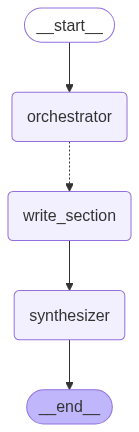

In [34]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Then, you can run the workflow. 

In [35]:
workflow.invoke({"topic": "Substance abuse of athletes"})

{'topic': 'Substance abuse of athletes',
 'sections': [Section(name='Introduction to Substance Abuse in Athletes', description='Overview of substance abuse issues commonly faced by athletes, including types of substances and reasons for usage.'),
  Section(name='Common Substances Abused by Athletes', description='Detailed description of substances frequently abused such as steroids, stimulants, painkillers, and recreational drugs.'),
  Section(name='Causes and Risk Factors', description='Exploration of psychological, social, and professional factors that contribute to substance abuse among athletes.'),
  Section(name='Health and Performance Consequences', description="Analysis of the physical and mental impacts of substance abuse on athletes' health and sports performance."),
  Section(name='Detection and Prevention Strategies', description='Information on how substance abuse is detected in athletes and strategies used to prevent it, including testing and education programs.'),
  Secti

Finally, I'll show you how to implement a evaluator-optimizer workflow. 

### Evaluator-optimizer

This workflow is useful when we have clear evaluation criteria that an LLM evaluator can use to provide feedback to the LLM generator to iteratively improve its output.

Here's what the workflow looks like:

```{mermaid}
flowchart LR
    In([In]) --> Gen["Generator (LLM)"]
    Gen -- "Solution" --> Eval["Evaluator (LLM)"]
    Eval -- "Accepted" --> Out([Out])
    Eval -- "Rejected + Feedback" --> Gen
```

**Examples:**

- Content generation that must match certain guidelines such as writing with a particular style.
- Improving search results iteratively

I'll walk you through an example of an evaluator-optimizer workflow where you'll generate a text, evaluate if it matches certain criteria, and then iteratively improve it.

Let's start with the vanilla implementation.

#### Vanilla (+LangChain)

As usual, you start by defining the state and required data models.

In [36]:
class Evaluation(BaseModel):
    explanation: str = Field(
        description="Explain why the text evaluated matches or not the evaluation criteria"
    )
    feedback: str = Field(
        description="Provide feedback to the writer to improve the text"
    )
    is_correct: bool = Field(
        description="Whether the text evaluated matches or not the evaluation criteria"
    )


class State(BaseModel):
    topic: str
    article: Optional[str] = None
    evaluation: Optional[Evaluation] = None

Then, you define the functions for each step in the workflow. 

In [37]:
def evaluate_text(state: State) -> Evaluation:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's written in British English and if it's appropriate for a young audience. The text must always use British spelling and grammar. Make sure the text doesn't include any em dashes."
        ),
        HumanMessage(content=f"Evaluate the following text:\n\n{state.article}"),
    ]
    response = model_with_str_output.invoke(messages)
    return response


def fix_text(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a text and feedback, you wil improve the text."
        ),
        HumanMessage(
            content=f"You were tasked with writing an article about {state.topic}. You wrote the following text:\n\n{state.article}\n\nYou've got the following feedback:\n\n{state.evaluation.feedback}\n\nFix the text to improve it."
        ),
    ]
    response = model.invoke(messages)
    return response.content


def generate_text(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a topic, you will generate an engaging article with less than 500 words."
        ),
        HumanMessage(content=f"Generate a text about this topic:\n\n{state.topic}"),
    ]
    response = model.invoke(messages)
    return response.content


def generate_text_dispatch(state: State) -> str:
    if state.evaluation:
        return fix_text(state)
    return generate_text(state)

Finally, you create `run_workflow` function that orchestrates the workflow. In this case, it takes a topic, generates a text, evaluates it, and tries to iteratively improve it. If it fails more than 3 times, it stops.

In [38]:
def run_workflow(topic: str) -> State:
    state = State(topic=topic)
    for _ in range(4):
        state.article = generate_text_dispatch(state)
        state.evaluation = evaluate_text(state)
        if state.evaluation.is_correct:
            return state
    return state


output = run_workflow("Substance abuse of athletes")

Next, let's see the LangGraph implementation. 

#### LangGraph

You'll start by defining the state of the workflow and data model required for the workflow. 

In [39]:
class Evaluation(BaseModel):
    explanation: str
    feedback: str
    is_correct: bool


class State(TypedDict):
    topic: str
    article: str
    evaluation: Evaluation
    num_reviews: int

In this case, you keep the number of reviews in the state. That's how you'll be able to stop the workflow when the number of reviews is reached.

Next, you must define the functions for each node in the workflow.

In [40]:
def generate_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a topic, you will generate an engaging article with less than 500 words."
        ),
        HumanMessage(content=f"Generate a text about this topic:\n\n{state['topic']}"),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def fix_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a text, you will fix the text to improve it. The text must always use British spelling and grammar."
        ),
        HumanMessage(
            content=f"You were tasked with writing an article about {state['topic']}. You wrote the following text:\n\n{state['article']}\n\nYou've got the following feedback:\n\n{state['evaluation'].feedback}\n\nFix the text to improve it."
        ),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def evaluate_article(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's written in British English and if it's appropriate for a young audience. The text must always use British spelling and grammar. Make sure the text doesn't include any em dash. Be very strict with the evaluation. In case of doubt, return a negative evaluation."
        ),
        HumanMessage(content=f"Evaluate the following text:\n\n{state['article']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluation": response, "num_reviews": state.get("num_reviews", 0) + 1}


def route_text(state: State) -> str:
    evaluation = state.get("evaluation", None)
    num_reviews = state.get("num_reviews", 0)
    if evaluation and not evaluation.is_correct and num_reviews < 3:
        return "Fail"
    return "Pass"


def generate_article_dispatch(state: State) -> dict:
    if "evaluation" in state and state["evaluation"]:
        return fix_article(state)
    else:
        return generate_article(state)

You define:

1. `generate_text`: This function generates a text based on the topic.
2. `evaluate_text`: This function evaluates the text based on the topic.
3. `fix_text`: This function fixes the text based on the feedback.
4. `generate_article_dispatch`: This function dispatches the text generation task to either the `generate_text` or `fix_text` function based on the evaluation.

Next, you need to define the graph that will be used to run the workflow. 

In [41]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_article", generate_article_dispatch)
workflow_builder.add_node("evaluate_article", evaluate_article)

workflow_builder.add_edge(START, "generate_article")
workflow_builder.add_edge("generate_article", "evaluate_article")
workflow_builder.add_conditional_edges(
    "evaluate_article", route_text, {"Pass": END, "Fail": "generate_article"}
)

workflow = workflow_builder.compile()

You start by defining the workflow's architecture with a StateGraph object. Your functions are then brought in as the nodes, and the operational sequence between them is set by defining the edges. Similar to the *Prompt chaining* pattern, you can use a conditional edge to dynamically route the workflow's logic based on its current state. But instead of routing to a node, you route back to the text generation node, and iterate until the text is good enough.

Next, you call the `compile` method to convert your graph into a runnable workflow. You can also generate a visual diagram of the workflow using the `get_graph` and `draw_mermaid_png` functions.

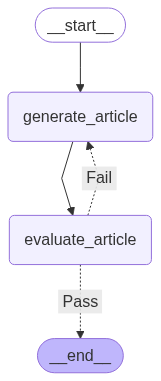

In [42]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Finally, you can run the workflow with the `invoke` method.

In [43]:
workflow.invoke({"topic": "Suggest the use enhancing drugs to athletes"})

{'topic': 'Suggest the use enhancing drugs to athletes',
 'article': 'The use of performance-enhancing drugs (PEDs) in sports is a complicated and sensitive topic. These substances are said to help athletes improve their abilities and compete better. However, their use raises important questions about fairness, health, and rules. While some people believe that carefully controlled use of PEDs might have certain benefits, it is a subject that needs thoughtful discussion and clear regulation.\n\nSupporters of PEDs argue that they could make competitions fairer by helping athletes who do not have the same access to training and equipment. In many sports, very small differences can decide the winner, and some athletes may use these drugs to try to even the playing field. If used properly under medical supervision, PEDs might reduce inequalities caused by differences in coaching and resources.\n\nAnother point is that if doctors monitored athletes using these substances, health risks could 

That's it! You've now seen how to implement the most common agentic workflow patterns with a vanilla approach and with LangGraph. 

## Conclusion

Throughout this tutorial, you've seen how different agentic workflow patterns solve specific types of problems:

- **Prompt Chaining**: Break complex tasks into sequential steps with clear handoffs
- **Routing**: Classify inputs and route them to specialized handlers
- **Parallelization**: Run multiple evaluations or processes simultaneously for speed and diversity
- **Orchestrator-Workers**: Dynamically decompose tasks and distribute work
- **Evaluator-Optimizer**: Create feedback loops for iterative quality improvement

You've learned how to implement these patterns with and without LangGraph. While the vanilla approach give you full control and might be simpler for basic cases, LangGraph gives you many features that make it easier to build complex workflows.

Hope you find this tutorial useful. If you have any questions, let me know in the comments below.